# NPZ model and synthetic observations

## some preparation: 
create synthetic (model-generated) data

In [2]:
import numpy as np

# specify indices
i_n = 0
i_p = 1
i_z = 2

# specify parameter values
theta = {
    'vmax':0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat':0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz':0.02,        # zooplankton grazing rate
    'mort_p':0.02,      # phytoplankton mortality rate
    'mort_z':0.03,      # zooplankton mortality rate
    'irr':0.8,          # light amplitude
}

# specify model 
def dxdt(x,t,theta):
    '''
    input
    =====
    x: model state
    theta: model parameters
    '''
    light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])
    growth = theta['vmax']*x[i_n]/(theta['nuthalfsat']+x[i_n]) * light * x[i_p]
    grazing = theta['graz']*x[i_p]*x[i_z]
    ploss = theta['mort_p']*x[i_p]
    zloss = theta['mort_z']*x[i_z]*x[i_z]
    return np.array((-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss))

run the model

In [3]:
from scipy.integrate import odeint

# initial conditions
x0 = (0.6,0.15,0.23)

# initialize time vector
t = np.arange(0.0,2*365.0,1.0)

x = odeint(dxdt, x0, t, args=(theta,))

set indices for observation extractions and generate synthetic observations

In [4]:
iobs = np.random.choice(len(t)//10, 20, replace=False)*10
iobs.sort()

iobsvar = np.array([i_p,i_n])
sigma = np.array([0.03,0.03])

tobs = t[iobs]
obs = np.maximum(0.0, x[iobs,:][:,iobsvar] + np.random.normal(size=(iobs.size,iobsvar.size))*sigma)

plot data

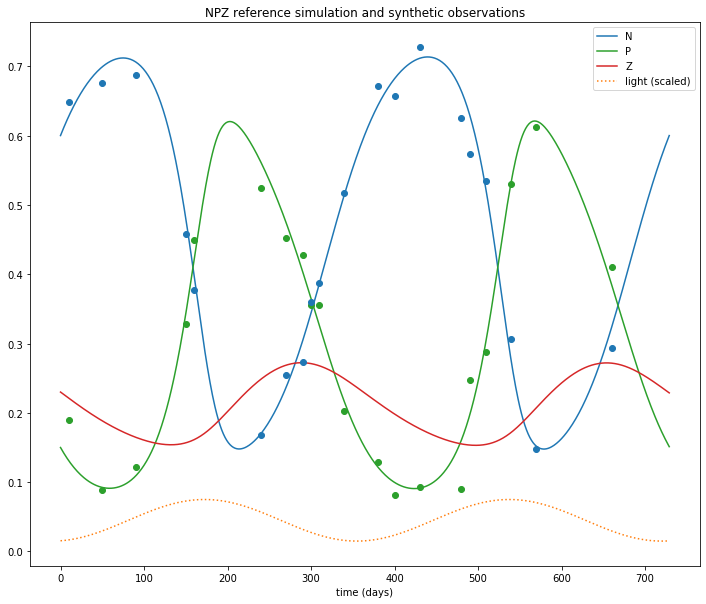

In [5]:
colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,10))
for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
ax.plot(t,theta['vmax']*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
for i, ivar in enumerate(iobsvar):
    ax.plot(tobs, obs[:,i], color=colors[ivar], marker='o', ls='none')
ax.set(title='NPZ reference simulation and synthetic observations', xlabel='time (days)')
ax.legend()

## create and run Stan model

In [6]:
stan_code = '''
functions {
   real[] npz(real t,       // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[] x_i) {  // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr          light amplitude
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = 1.0 + 0.5*(theta[6]*sin(pi()*((t-81.25)/182.5))-theta[6]); 
    real growth = theta[1]*n/(theta[2]+n) * light * p;
    real grazing = theta[3]*p*z;
    real ploss = theta[4]*p;
    real zloss = theta[5]*z*z;
    
    return {-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss};
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0,upper=1> irr;
    real<lower=0> x0[3];            // initial conditions
    real<lower=0> sigma[nobsvar];   // obs error
}
transformed parameters {
    real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
    real x[nobs, 3] = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                                         rep_array(0.0, 0), rep_array(0, 0),
                                         1e-5, 1e-4, 1e4);
}
model {
    vmax       ~ normal(0.1, 0.1);
    nuthalfsat ~ uniform(0.0, 1.0);
    graz       ~ normal(0.01, 0.01);
    mort_p     ~ normal(0.01, 0.01);
    mort_z     ~ normal(0.01, 0.01);
    irr        ~ uniform(0.0, 1.0);
    x0[1:3]    ~ normal(0.1, 0.1);
    for (iobs in 1:nobs){
        obs[iobs,] ~ normal(x[iobs,iobsvar], sigma);
    }
}
'''

In [7]:
import pystan

model = pystan.StanModel(model_code=stan_code)

# convert from Python's 0-based indexing to Stan's 1-based
data = {'nobs':len(tobs), 'tobs':tobs, 'nobsvar':len(iobsvar), 'iobsvar':iobsvar+1, 'obs':obs}

mcmc = model.sampling(data=data, iter=2000, chains=4)
print(mcmc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00918706f3db6263d5fd0d4e61a1c110 NOW.


Inference for Stan model: anon_model_00918706f3db6263d5fd0d4e61a1c110.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax         0.09  6.0e-4   0.01   0.07   0.08   0.09    0.1   0.12    514   1.01
nuthalfsat   0.61  8.1e-3   0.19   0.27   0.46   0.61   0.76   0.96    571   1.01
graz         0.01  1.2e-4 3.8e-3 6.6e-3   0.01   0.01   0.02   0.02    917    1.0
mort_p       0.02  1.2e-4 3.4e-3   0.01   0.01   0.02   0.02   0.02    750    1.0
mort_z       0.02  2.1e-4 7.1e-3 9.8e-3   0.02   0.02   0.03   0.04   1125   1.01
irr          0.92  2.4e-3   0.06   0.77   0.89   0.94   0.97    1.0    678    1.0
x0[1]        0.57  1.7e-3   0.03   0.49   0.55   0.57   0.59   0.62    339   1.01
x0[2]        0.17  5.5e-4   0.02   0.14   0.16   0.17   0.18    0.2    767    1.0
x0[3]        0.23  1.5e-3   0.05   0.14    0.2   0.23   0.27   0.34   110

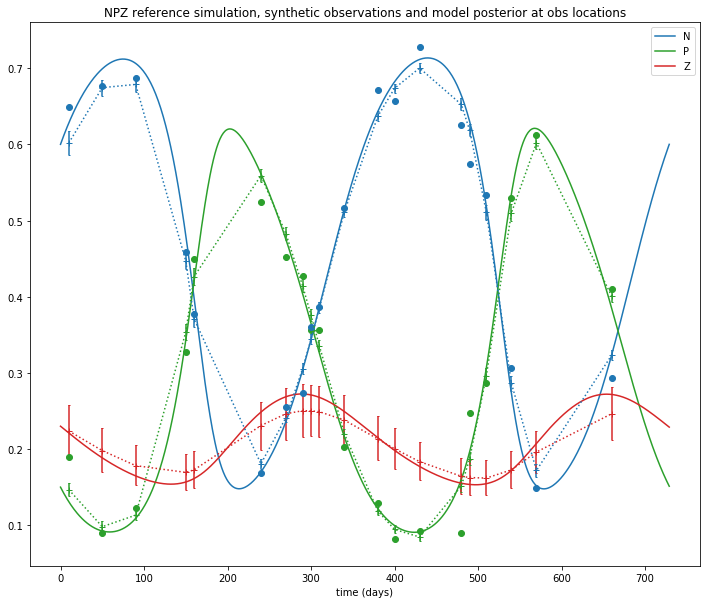

In [8]:
# plot results

x_quant = np.percentile(mcmc['x'], (25,50,75), axis=0)

fig,ax = plt.subplots(figsize=(12,10))

for i,name in enumerate(('N','P','Z')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
    ax.errorbar(x=tobs, y=x_quant[1,:,i], yerr=np.array((x_quant[1,:,i]-x_quant[0,:,i],x_quant[2,:,i]-x_quant[1,:,i])), ls=':', color=colors[i], marker='+', capsize=1.0)
for i, ivar in enumerate(iobsvar):
    ax.plot(tobs, obs[:,i], color=colors[ivar], marker='o', ls='none')
ax.set(title='NPZ reference simulation, synthetic observations and model posterior at obs locations', xlabel='time (days)')
ax.legend()
None

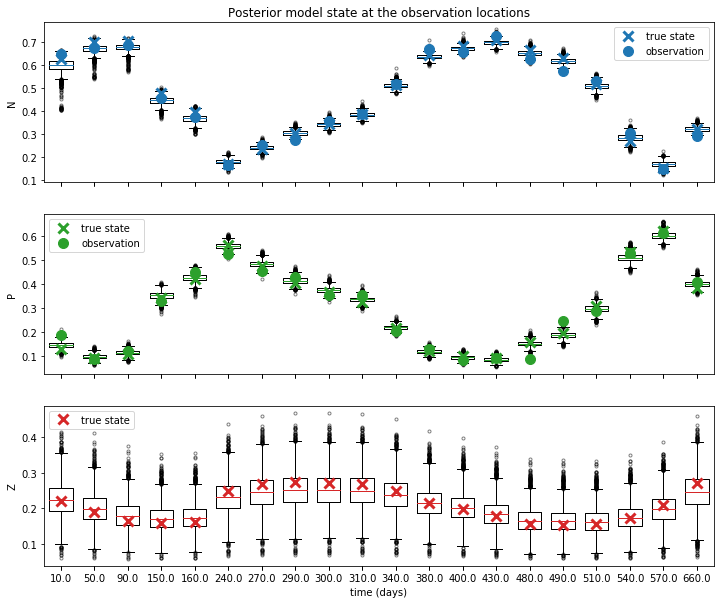

In [9]:
positions = range(len(tobs))

fig,axs = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
for ivar,ax in enumerate(axs.flat):
    ax.boxplot(mcmc['x'][:,:,ivar], positions=positions, medianprops={'color':colors[ivar]}, flierprops={'marker':'.', 'alpha':0.5}, widths=0.7)
    ax.plot(positions, x[iobs,ivar], marker='x', markeredgewidth=3, markersize=10, ls='none', label='true state', color=colors[ivar])
    ax.set(ylabel='NPZ'[ivar])
for i,ivar in enumerate(iobsvar):
    axs[ivar].plot(positions, obs[:,i], marker='o', markersize=10, ls='none', label='observation', color=colors[ivar])
for ax in axs.flat:
    ax.legend()
axs[0].set(title='Posterior model state at the observation locations')
axs[-1].set(xticklabels=tobs, xlabel='time (days)')
None

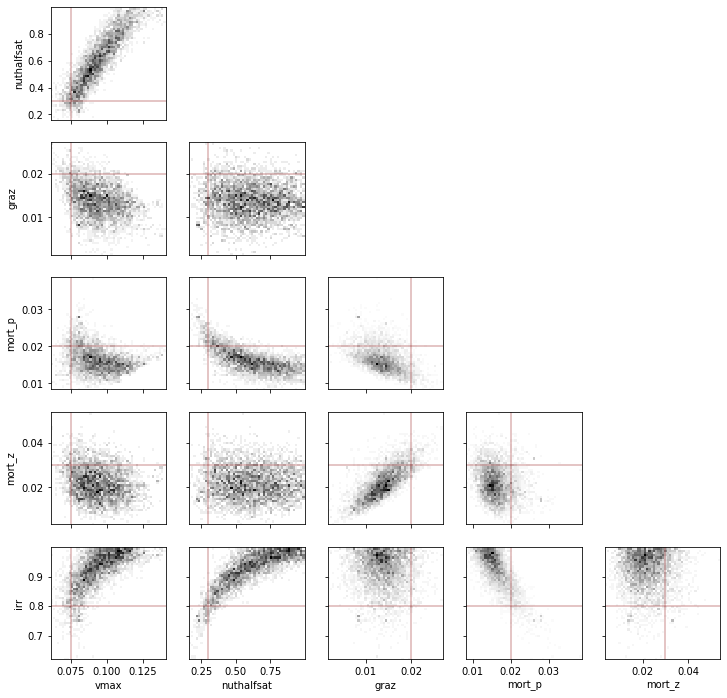

In [10]:
parameter_names = [k for k in theta.keys()]
nparam = len(parameter_names)
cmap = plt.get_cmap('gray_r')

fig,axs = plt.subplots(nrows=nparam-1, ncols=nparam-1, sharex='col', sharey='row', figsize=(12,12))
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,nparam):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = parameter_names[icol]
        yname = parameter_names[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=cmap)
        ax.axvline(theta[xname], color='darkred', alpha=0.3)
        ax.axhline(theta[yname], color='darkred', alpha=0.3)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == nparam-1:
            ax.set_xlabel(xname)